In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
#mnist_transform = transforms.Compose([
#                transforms.ToTensor(),
#                transforms.Normalize((0.5,), (0.5,)),
#           ])
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [3]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [4]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, sparse=None, rho=1., optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.sparse = sparse
        self.rho = rho
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        
        if self.sparse == 'KL':
            self.latent_fn = nn.Sigmoid()
        else:
            self.latent_fn = nn.Tanh()
            
        self.fce = FullyConnected([32*2*2, 32])
        self.fcd = FullyConnected([32, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        self.h = self.latent_fn(self.fce(flatten))
        return self.h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
        
    def forward(self, x):
        h = self.encode(x)
        x = self.decode(h)
        return x
    
    def loss(self, output, target):
        if self.sparse == 'KL':
            h_mean = self.h.mean(0)
            sparse_loss = - torch.log(h_mean) * self.rho - torch.log(1-h_mean) * (1-self.rho)
            self.sparse_loss = sparse_loss.mean()
        elif self.sparse == 'L1':
            h_abs = torch.abs(self.h)
            self.sparse_loss = self.rho*h_abs.mean()
        else:
            self.sparse_loss = 0.
            
        self._loss = F.mse_loss(output, target) + self.sparse_loss
        
        return self._loss

In [7]:
models = {
    #'RMSProp KL': Net(False, False, sparse='KL', rho=0.2, optim_type='RMSProp', lr=1e-4),
    'RMSProp+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='RMSProp', lr=1e-4),    
    #'Adam KL': Net(False, False, sparse='KL', rho=0.2, optim_type='Adam', lr=1e-4),
    'Adam L1': Net(False, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn+dp L1': Net(True, True, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4)
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)             
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [9]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.8f}\n'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.175810 Adam L1: 0.115380 Adam+bn L1: 0.150796 Adam+bn+dp L1: 0.288129
Train Epoch: 1 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.049429 Adam L1: 0.070293 Adam+bn L1: 0.063594 Adam+bn+dp L1: 0.086327
Train Epoch: 1 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.037949 Adam L1: 0.059850 Adam+bn L1: 0.046836 Adam+bn+dp L1: 0.061622
Train Epoch: 1 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.035960 Adam L1: 0.052119 Adam+bn L1: 0.043980 Adam+bn+dp L1: 0.051690
Train Epoch: 1 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.027548 Adam L1: 0.038603 Adam+bn L1: 0.033737 Adam+bn+dp L1: 0.039280
Train Epoch: 1 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.022501 Adam L1: 0.031642 Adam+bn L1: 0.029094 Adam+bn+dp L1: 0.031542
Test losses: RMSProp+bn L1: 0.02284312
 Adam L1: 0.03357703
 Adam+bn L1: 0.02896067
 Adam+bn+dp L1: 0.03301513

Train Epoch: 2 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.022905 Adam L1: 0.032792 Adam+bn L1: 0.029234 Adam+bn+dp L1: 0.0

Train Epoch: 10 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.010197 Adam L1: 0.009985 Adam+bn L1: 0.009527 Adam+bn+dp L1: 0.010723
Train Epoch: 10 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.010397 Adam L1: 0.009725 Adam+bn L1: 0.009742 Adam+bn+dp L1: 0.010724
Train Epoch: 10 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.008084 Adam L1: 0.007603 Adam+bn L1: 0.007587 Adam+bn+dp L1: 0.008032
Train Epoch: 10 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.010064 Adam L1: 0.009415 Adam+bn L1: 0.009735 Adam+bn+dp L1: 0.009935
Test losses: RMSProp+bn L1: 0.00871160
 Adam L1: 0.00874715
 Adam+bn L1: 0.00846537
 Adam+bn+dp L1: 0.00897732

Train Epoch: 11 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.009397 Adam L1: 0.008859 Adam+bn L1: 0.009029 Adam+bn+dp L1: 0.009520
Train Epoch: 11 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.008510 Adam L1: 0.008650 Adam+bn L1: 0.008082 Adam+bn+dp L1: 0.009372
Train Epoch: 11 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.008046 Adam L1: 0.007890 Adam+bn L1: 0.008072 Adam+b

Train Epoch: 19 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.007528 Adam L1: 0.006698 Adam+bn L1: 0.006921 Adam+bn+dp L1: 0.007561
Train Epoch: 19 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.008422 Adam L1: 0.007829 Adam+bn L1: 0.008423 Adam+bn+dp L1: 0.008486
Test losses: RMSProp+bn L1: 0.00764409
 Adam L1: 0.00720938
 Adam+bn L1: 0.00723889
 Adam+bn+dp L1: 0.00740206

Train Epoch: 20 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.007881 Adam L1: 0.007049 Adam+bn L1: 0.007909 Adam+bn+dp L1: 0.007861
Train Epoch: 20 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.007553 Adam L1: 0.006924 Adam+bn L1: 0.007082 Adam+bn+dp L1: 0.007187
Train Epoch: 20 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.008195 Adam L1: 0.006809 Adam+bn L1: 0.007854 Adam+bn+dp L1: 0.008084
Train Epoch: 20 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.007911 Adam L1: 0.007268 Adam+bn L1: 0.007422 Adam+bn+dp L1: 0.007620
Train Epoch: 20 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.007132 Adam L1: 0.006597 Adam+bn L1: 0.006758 Adam+b

Test losses: RMSProp+bn L1: 0.00688281
 Adam L1: 0.00654172
 Adam+bn L1: 0.00674326
 Adam+bn+dp L1: 0.00675385

Train Epoch: 29 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.007325 Adam L1: 0.006633 Adam+bn L1: 0.007360 Adam+bn+dp L1: 0.007447
Train Epoch: 29 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.006868 Adam L1: 0.006184 Adam+bn L1: 0.006767 Adam+bn+dp L1: 0.006693
Train Epoch: 29 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.007014 Adam L1: 0.006434 Adam+bn L1: 0.006671 Adam+bn+dp L1: 0.007074
Train Epoch: 29 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.006767 Adam L1: 0.006099 Adam+bn L1: 0.006427 Adam+bn+dp L1: 0.006575
Train Epoch: 29 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.007764 Adam L1: 0.007072 Adam+bn L1: 0.007586 Adam+bn+dp L1: 0.007334
Train Epoch: 29 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.007459 Adam L1: 0.006196 Adam+bn L1: 0.006786 Adam+bn+dp L1: 0.006937
Test losses: RMSProp+bn L1: 0.00716795
 Adam L1: 0.00650313
 Adam+bn L1: 0.00668143
 Adam+bn+dp L1: 0.00668816



Train Epoch: 38 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.006910 Adam L1: 0.005934 Adam+bn L1: 0.006860 Adam+bn+dp L1: 0.006896
Train Epoch: 38 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.006410 Adam L1: 0.005900 Adam+bn L1: 0.006448 Adam+bn+dp L1: 0.006277
Train Epoch: 38 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.006477 Adam L1: 0.006150 Adam+bn L1: 0.006442 Adam+bn+dp L1: 0.006538
Train Epoch: 38 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.006835 Adam L1: 0.006032 Adam+bn L1: 0.006433 Adam+bn+dp L1: 0.006800
Train Epoch: 38 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.006982 Adam L1: 0.006064 Adam+bn L1: 0.006640 Adam+bn+dp L1: 0.006645
Test losses: RMSProp+bn L1: 0.00651491
 Adam L1: 0.00613785
 Adam+bn L1: 0.00648924
 Adam+bn+dp L1: 0.00649384

Train Epoch: 39 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.008551 Adam L1: 0.006540 Adam+bn L1: 0.008036 Adam+bn+dp L1: 0.008274
Train Epoch: 39 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.006903 Adam L1: 0.006007 Adam+bn L1: 0.006955 Adam+b

In [12]:
torch.save(models['RMSProp+bn L1'], './rms_bn_l1')
torch.save(models['Adam L1'], './adam_l1')
torch.save(models['Adam+bn L1'], './adam_bn_l1')
torch.save(models['Adam+bn+dp L1'], './adam_bn_dp_l1')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for containe

## Вывод результатов

In [22]:
model = torch.load('./adam_l1')

In [24]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((abs(encoded) > 0.05).sum(1))
    encoded[abs(encoded) < 0.05] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 10,  13,   4,   8,  10,   5,  10,  13,  13,   8,  11,  16,
          6,  11,   6,  16,   8,  13,  12,   7,  11,   9,  15,  12,
          8,  11,  10,   7,   7,   6,   9,   7,   9,  12,  10,  15,
         11,   6,  13,   3,   7,  12,  14,  11,  13,   7,  11,   9,
         10,  10])


Исходные данные


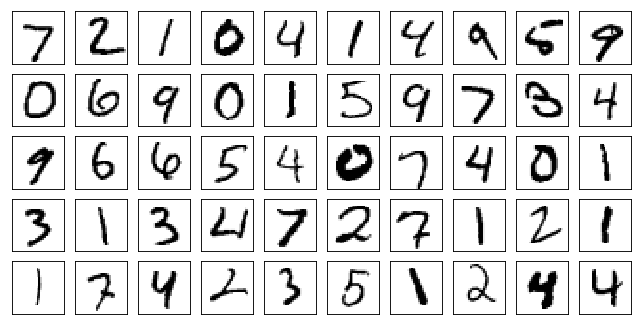

Выход декодера


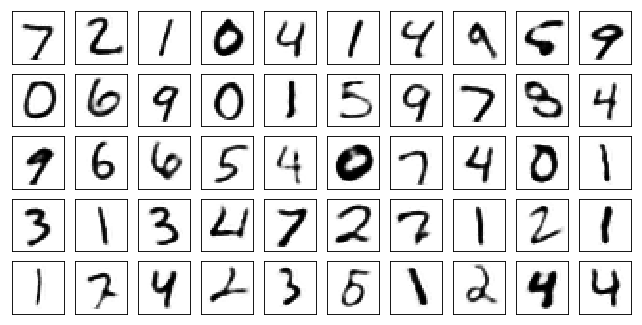

Выход декодера с отсечкой на латентном слое


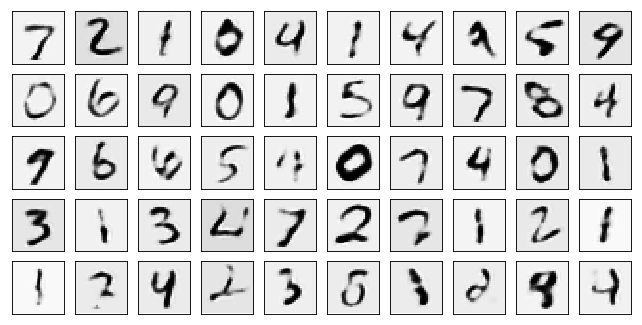

Выход декодера с единичной матрицы


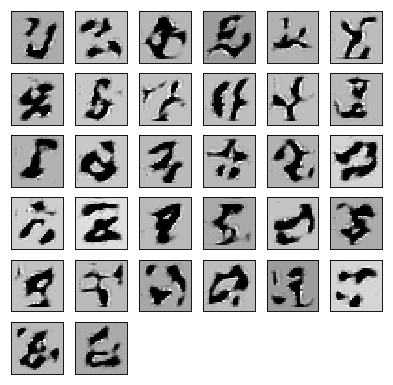

In [25]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

In [26]:
model = torch.load('./adam_bn_dp_l1')

In [27]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((np.abs(encoded) > 0.05).sum(1))
    encoded[np.abs(encoded) < 0.05] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  9,  13,   6,  10,   9,   3,  13,  10,  15,   6,   7,  11,
          6,   6,   5,   9,   8,  11,  15,   5,   5,   7,  11,   9,
          7,  13,  10,   7,   9,   9,   9,   7,   6,  14,   8,   9,
         11,   8,   9,   4,   5,   9,   7,  10,   7,   6,  11,  12,
          7,   8])


Исходные данные


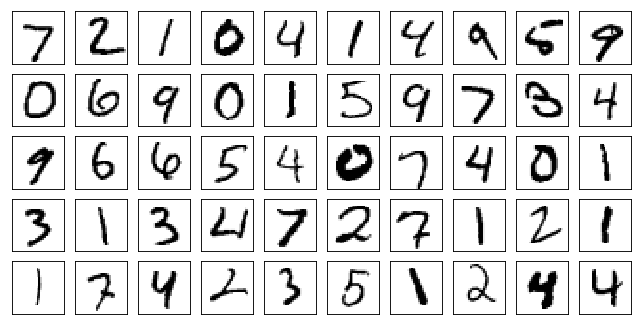

Выход декодера


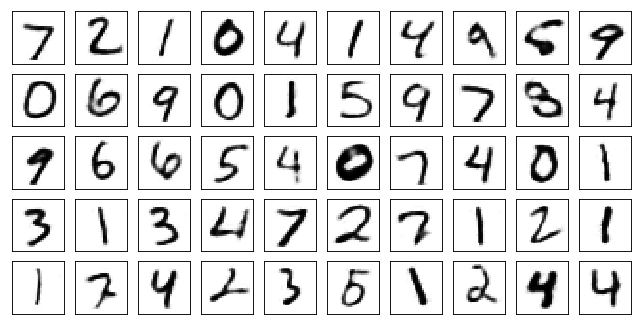

Выход декодера с отсечкой на латентном слое


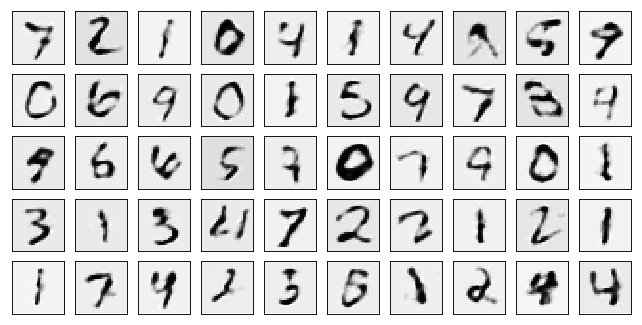

Выход декодера с единичной матрицы


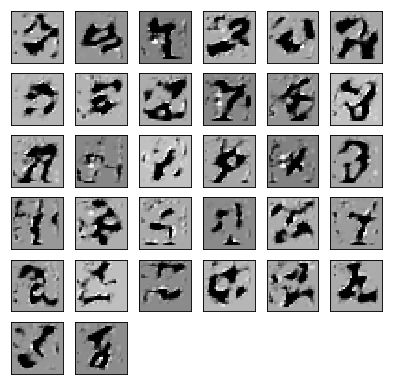

In [28]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

### Оптимизация изображений на входе автокодировщика

In [29]:
model = torch.load('./adam_l1')

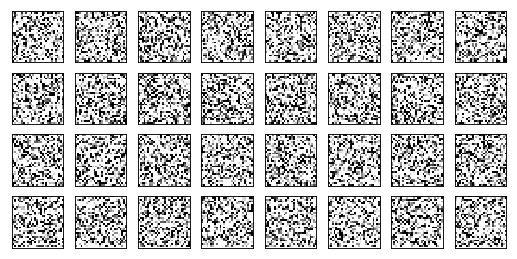

In [30]:
img = torch.randn((32, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [31]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(32)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-3
    
    
    for i in range(1, 100001):  
                
        target = model.encode(F.sigmoid(gen_img_par))
                
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
        
                       
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

Iteration 5000: loss=0.014658937230706215
Iteration 10000: loss=0.012313246726989746
Iteration 15000: loss=0.011616604402661324
Iteration 20000: loss=0.011274541728198528
Iteration 25000: loss=0.011049116030335426
Iteration 30000: loss=0.010893440805375576
Iteration 35000: loss=0.010790567845106125
Iteration 40000: loss=0.01071539893746376
Iteration 45000: loss=0.010655969381332397
Iteration 50000: loss=0.01060920674353838


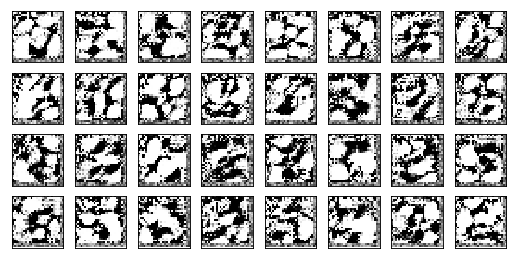

Iteration 55000: loss=0.010571247898042202
Iteration 60000: loss=0.010539532639086246
Iteration 65000: loss=0.010511008091270924
Iteration 70000: loss=0.010480554774403572
Iteration 75000: loss=0.010458986274898052
Iteration 80000: loss=0.01044239941984415
Iteration 85000: loss=0.010428392328321934
Iteration 90000: loss=0.010414907708764076
Iteration 95000: loss=0.010401449166238308
Iteration 100000: loss=0.010392124764621258


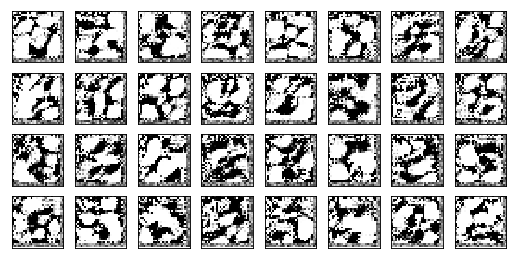

In [32]:
new_image_randn = generate_image(img)

### Оптимизация изображений - фильтры энкодера

In [33]:
def generate_filter_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(16)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-4
        
    for i in range(1, 200001):  
                
        target = model._conv1(F.sigmoid(gen_img_par))
        
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target.view(16, 16), latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (4, 4))
                        
    return gen_img_par    

In [34]:
img = torch.randn((16, 16)).view(16, 1, 4, 4)

Iteration 5000: loss=0.0669734925031662
Iteration 10000: loss=0.05145518109202385
Iteration 15000: loss=0.04128420352935791
Iteration 20000: loss=0.035004377365112305
Iteration 25000: loss=0.0312267504632473
Iteration 30000: loss=0.028954455628991127
Iteration 35000: loss=0.027586352080106735
Iteration 40000: loss=0.026759754866361618
Iteration 45000: loss=0.02626228705048561
Iteration 50000: loss=0.025961987674236298


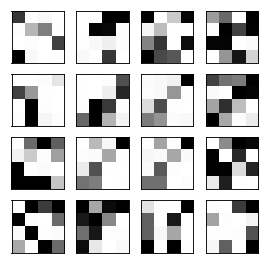

Iteration 55000: loss=0.025779133662581444
Iteration 60000: loss=0.02566712349653244
Iteration 65000: loss=0.02559797465801239
Iteration 70000: loss=0.025554846972227097
Iteration 75000: loss=0.0255274660885334
Iteration 80000: loss=0.02550971694290638
Iteration 85000: loss=0.025497885420918465
Iteration 90000: loss=0.025489751249551773
Iteration 95000: loss=0.02548399195075035
Iteration 100000: loss=0.025479769334197044


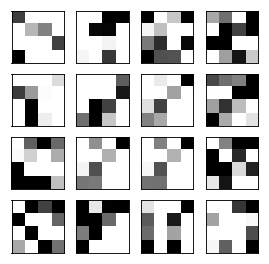

Iteration 105000: loss=0.025476591661572456
Iteration 110000: loss=0.02547413855791092
Iteration 115000: loss=0.02547217719256878
Iteration 120000: loss=0.025470590218901634
Iteration 125000: loss=0.025469280779361725
Iteration 130000: loss=0.025468187406659126
Iteration 135000: loss=0.025467250496149063
Iteration 140000: loss=0.02546645887196064
Iteration 145000: loss=0.02546576038002968
Iteration 150000: loss=0.025465134531259537


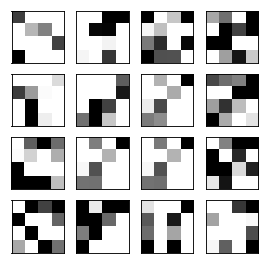

Iteration 155000: loss=0.025464605540037155
Iteration 160000: loss=0.025464139878749847
Iteration 165000: loss=0.02546372078359127
Iteration 170000: loss=0.025463350117206573
Iteration 175000: loss=0.025463014841079712
Iteration 180000: loss=0.025462718680500984
Iteration 185000: loss=0.0254624355584383
Iteration 190000: loss=0.02546219527721405
Iteration 195000: loss=0.02546195685863495
Iteration 200000: loss=0.025461750105023384


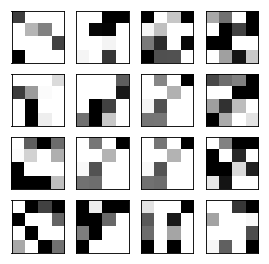

In [35]:
filter_img = generate_filter_image(img)

In [36]:
def generate_filter_image_conv2(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(32)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-4
        
    for i in range(1, 200001):  
                
        target = model._conv2(F.sigmoid(gen_img_par))
        
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        #print ("TR=",target.shape)
        #print ("LT=", latent_vector.shape)
        loss = F.mse_loss(target.view(32, 32), latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (16, 32))
                        
    return gen_img_par    

In [37]:
img = torch.randn((16, 32*4*4)).view(-1, 16, 4, 4)

Iteration 5000: loss=0.2361161857843399
Iteration 10000: loss=0.17933547496795654
Iteration 15000: loss=0.14305903017520905
Iteration 20000: loss=0.1185462549328804
Iteration 25000: loss=0.10258851945400238
Iteration 30000: loss=0.09117086231708527
Iteration 35000: loss=0.07810941338539124
Iteration 40000: loss=0.06210639327764511
Iteration 45000: loss=0.044148389250040054
Iteration 50000: loss=0.029598450288176537


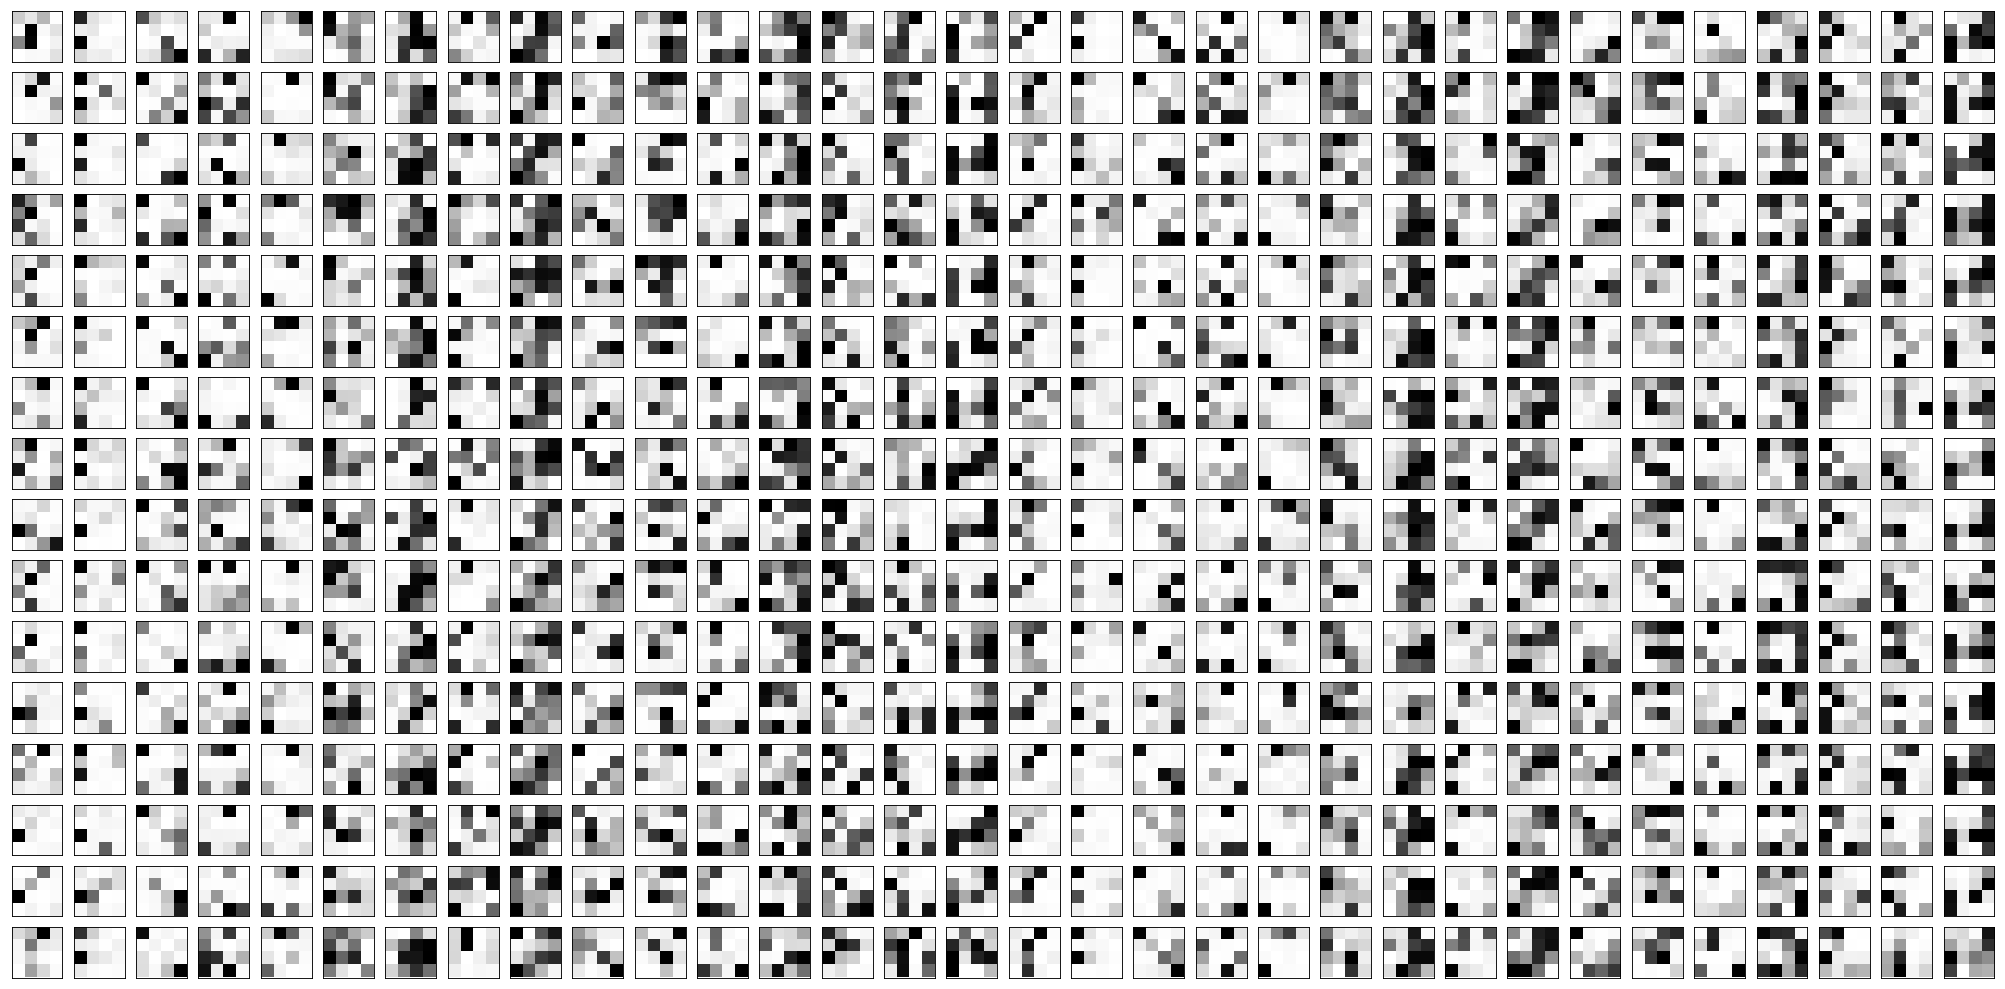

Iteration 55000: loss=0.019640179350972176
Iteration 60000: loss=0.013673042878508568
Iteration 65000: loss=0.009320114739239216
Iteration 70000: loss=0.006084463093429804
Iteration 75000: loss=0.003864697413519025
Iteration 80000: loss=0.002620051149278879
Iteration 85000: loss=0.0018876551184803247
Iteration 90000: loss=0.0016084894305095077
Iteration 95000: loss=0.0014522229321300983
Iteration 100000: loss=0.0013447628589347005


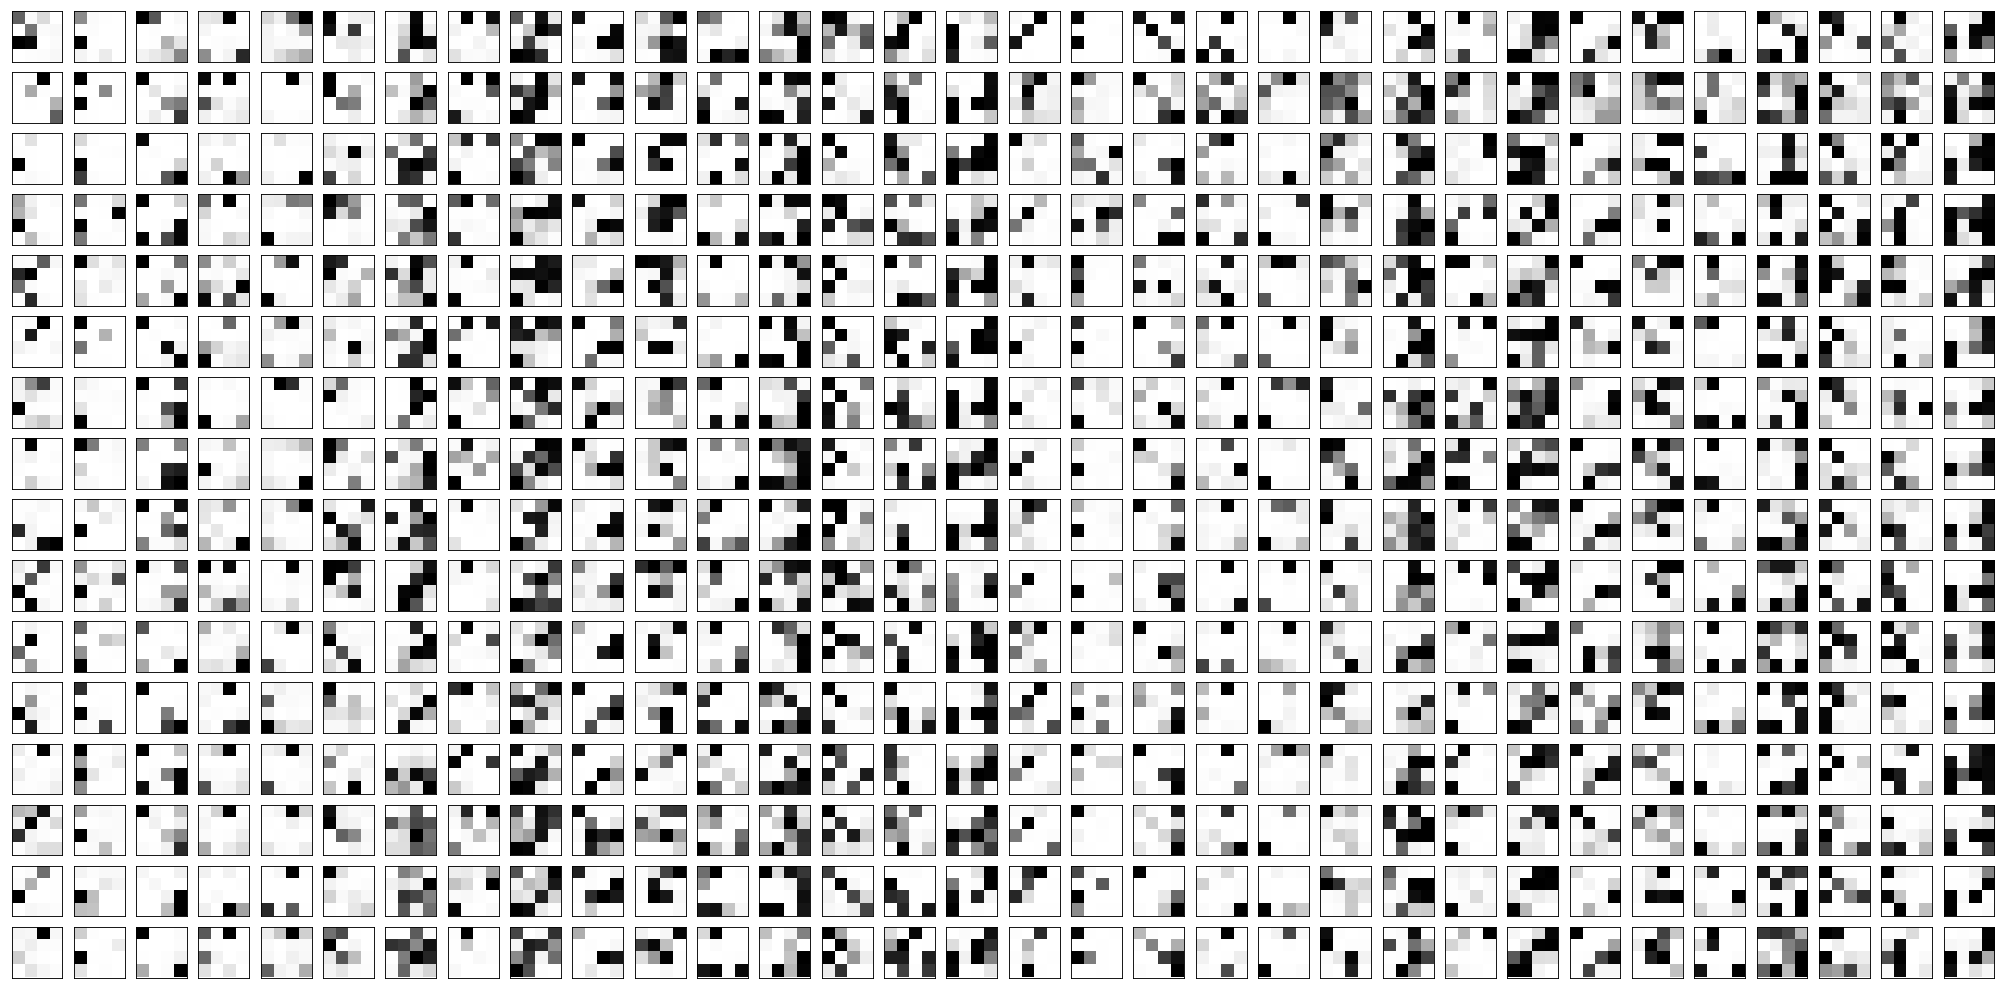

Iteration 105000: loss=0.0012661601649597287
Iteration 110000: loss=0.0012067507486790419
Iteration 115000: loss=0.0011606375919654965
Iteration 120000: loss=0.001124019268900156
Iteration 125000: loss=0.0010943427914753556
Iteration 130000: loss=0.001069868914783001
Iteration 135000: loss=0.0010493777226656675
Iteration 140000: loss=0.0010319933062419295
Iteration 145000: loss=0.001017065835185349
Iteration 150000: loss=0.0010041106725111604


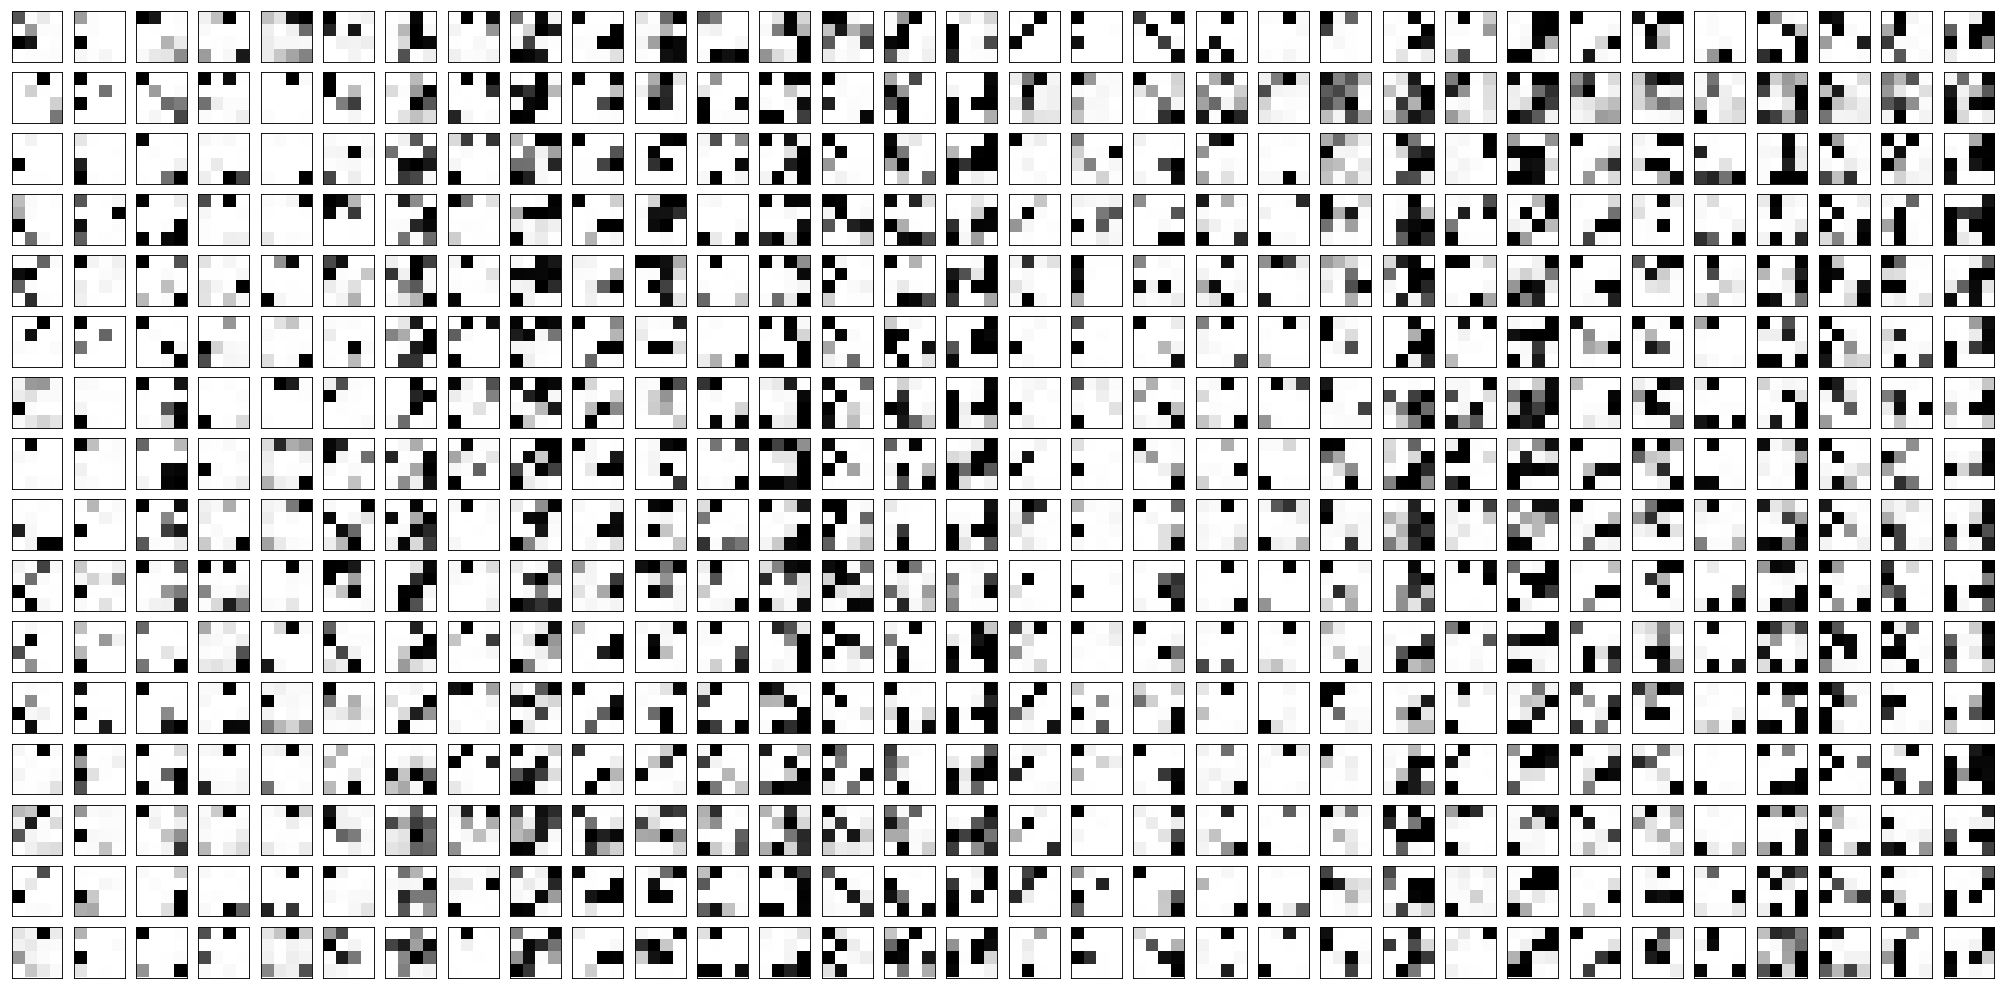

Iteration 155000: loss=0.0009927557548508048
Iteration 160000: loss=0.0009827171452343464
Iteration 165000: loss=0.0009737770888023078
Iteration 170000: loss=0.0009657589835114777
Iteration 175000: loss=0.0009585235384292901
Iteration 180000: loss=0.000951960391830653
Iteration 185000: loss=0.0009459744906052947
Iteration 190000: loss=0.0009404930169694126
Iteration 195000: loss=0.000935452408157289
Iteration 200000: loss=0.0009307996951974928


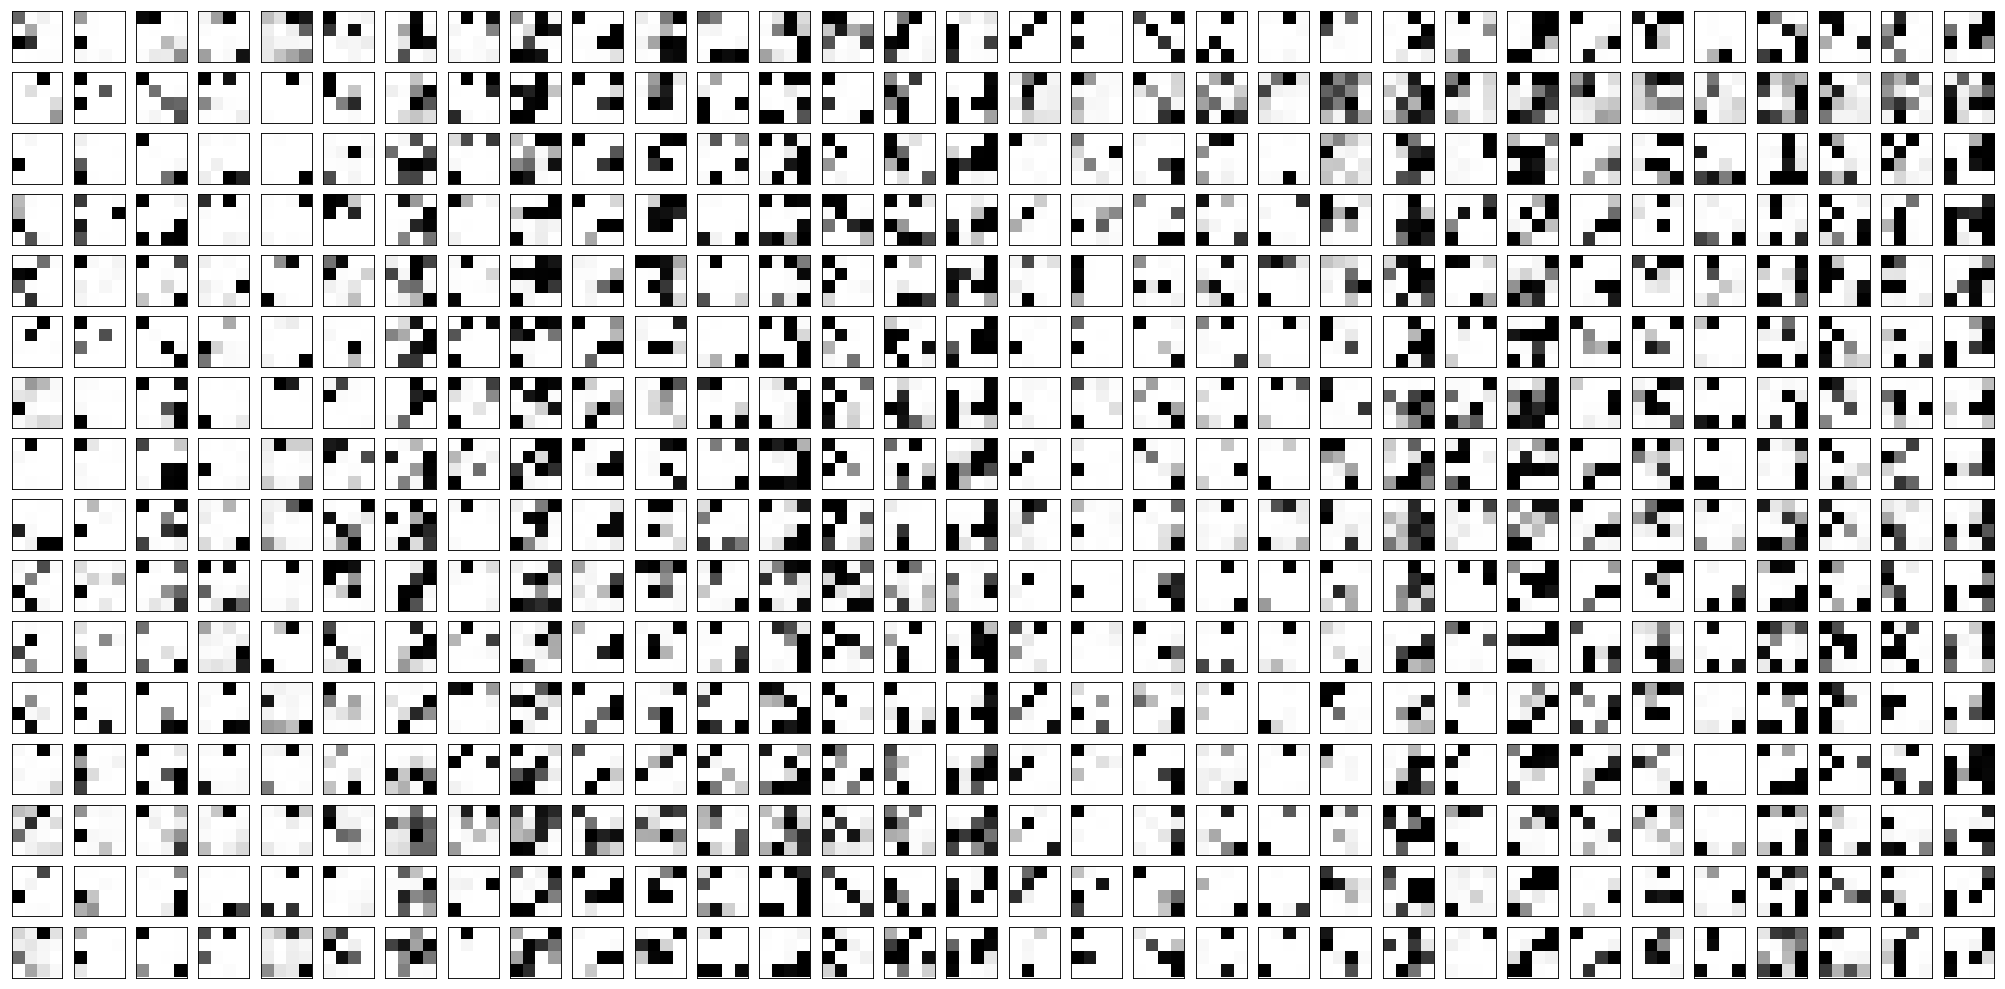

In [38]:
filter_img = generate_filter_image_conv2(img)